In [294]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as plt
import plotly.express as px
import shapely
from geopandas import GeoDataFrame,GeoSeries
import folium
import matplotlib
%matplotlib inline

In [295]:
#reading in all datasets
road_network = gpd.read_file('road_network_processed.geojson')
#road_network = gpd.read_file('ontario_road_network_processed.geojson')
bikelanes = gpd.read_file('cycling_network.geojson')
collisions = gpd.read_file('collisions_processed.geojson')
intersections = gpd.read_file('centreline_intersections_processed.geojson')
ksi = pd.read_csv('ksi_processed.csv')
lanes = gpd.read_file('lanes_processed.geojson')
pedestrian_crossings = gpd.read_file('pedestrian_crossover_processed.geojson')
sensitive_zones = gpd.read_file('sensitive_areas_processed_final.geojson')
speed_enforcement = gpd.read_file('speed_enforcement_processed.geojson')
speed_limits = gpd.read_file('speed_limits_processed.geojson')
traffic_calming = gpd.read_file('traffic_calming_processed.geojson')
traffic_cameras = gpd.read_file('traffic_cameras_processed.geojson')
traffic_volumes = pd.read_csv('traffic_volumes_processed_2.csv')

In [296]:
print(road_network.crs)
print(bikelanes.crs)
print(lanes.crs)
print(sensitive_zones.crs)
print(collisions.crs)

EPSG:4326
EPSG:4326
EPSG:4326
EPSG:4326
EPSG:4326


Main Dataset - Collisions

In [297]:
collisions.head()

,eventuniqueid,collisions_month,collisions_day_of_week,collisions_year,collisions_hour,collisions_division,collisions_neighbourhood,collisions_fatalities,collisions_injury_collisions,collisions_ftr_collisions,collisions_pd_collisions,collisions_longitude,collisions_latitude,collisions_fatal_collisions,collisions_time_of_day,geometry
0,GO-20168000055,January,Friday,2016,16,D42,LAmoreaux (117),0,NO,NO,YES,-79.319271,43.795851,NO,afternoon,POINT (-79.31927 43.79585)
1,GO-20168000056,January,Friday,2016,17,D54/D55,Woodbine Corridor (64),0,YES,NO,NO,-79.320851,43.683944,NO,evening,POINT (-79.32085 43.68394)
2,GO-20168000057,January,Friday,2016,19,D41,Kennedy Park (124),0,NO,YES,NO,-79.251653,43.732248,NO,evening,POINT (-79.25165 43.73225)
3,GO-20168000058,January,Friday,2016,3,D52,Bay Street Corridor (76),0,NO,NO,YES,-79.385522,43.646053,NO,night,POINT (-79.38552 43.64605)
4,GO-20168000059,January,Friday,2016,4,D41,Birchcliffe-Cliffside (122),0,NO,NO,YES,-79.284020,43.680810,NO,night,POINT (-79.28402 43.68081)


In [298]:
type(collisions)

geopandas.geodataframe.GeoDataFrame

In [299]:
#set eventuniqueid as index
collisions = collisions.set_index('eventuniqueid')

In [300]:
collisions.head()

,collisions_month,collisions_day_of_week,collisions_year,collisions_hour,collisions_division,collisions_neighbourhood,collisions_fatalities,collisions_injury_collisions,collisions_ftr_collisions,collisions_pd_collisions,collisions_longitude,collisions_latitude,collisions_fatal_collisions,collisions_time_of_day,geometry
eventuniqueid,,,,,,,,,,,,,,,
GO-20168000055,January,Friday,2016,16,D42,LAmoreaux (117),0,NO,NO,YES,-79.319271,43.795851,NO,afternoon,POINT (-79.31927 43.79585)
GO-20168000056,January,Friday,2016,17,D54/D55,Woodbine Corridor (64),0,YES,NO,NO,-79.320851,43.683944,NO,evening,POINT (-79.32085 43.68394)
GO-20168000057,January,Friday,2016,19,D41,Kennedy Park (124),0,NO,YES,NO,-79.251653,43.732248,NO,evening,POINT (-79.25165 43.73225)
GO-20168000058,January,Friday,2016,3,D52,Bay Street Corridor (76),0,NO,NO,YES,-79.385522,43.646053,NO,night,POINT (-79.38552 43.64605)
GO-20168000059,January,Friday,2016,4,D41,Birchcliffe-Cliffside (122),0,NO,NO,YES,-79.284020,43.680810,NO,night,POINT (-79.28402 43.68081)


In [301]:
#dropping unnecessary columns
collisions = collisions.drop(columns=['collisions_division','collisions_ftr_collisions','collisions_pd_collisions'])

#creating a new column as indicator for fatal or injury collisions

#definining function to get values for new columns
def collision_injury_fatal(row):
    if row['collisions_injury_collisions'] == "YES" or row['collisions_fatal_collisions'] == "YES":
        return "YES"
    else:
        return "NO"

#applying function on new column
collisions['collision_injury_fatal'] = collisions.apply(collision_injury_fatal, axis=1)


In [302]:
collisions.head()

,collisions_month,collisions_day_of_week,collisions_year,collisions_hour,collisions_neighbourhood,collisions_fatalities,collisions_injury_collisions,collisions_longitude,collisions_latitude,collisions_fatal_collisions,collisions_time_of_day,geometry,collision_injury_fatal
eventuniqueid,,,,,,,,,,,,,
GO-20168000055,January,Friday,2016,16,LAmoreaux (117),0,NO,-79.319271,43.795851,NO,afternoon,POINT (-79.31927 43.79585),NO
GO-20168000056,January,Friday,2016,17,Woodbine Corridor (64),0,YES,-79.320851,43.683944,NO,evening,POINT (-79.32085 43.68394),YES
GO-20168000057,January,Friday,2016,19,Kennedy Park (124),0,NO,-79.251653,43.732248,NO,evening,POINT (-79.25165 43.73225),NO
GO-20168000058,January,Friday,2016,3,Bay Street Corridor (76),0,NO,-79.385522,43.646053,NO,night,POINT (-79.38552 43.64605),NO
GO-20168000059,January,Friday,2016,4,Birchcliffe-Cliffside (122),0,NO,-79.284020,43.680810,NO,night,POINT (-79.28402 43.68081),NO


# Joining Bikelanes

In [303]:
#bikelanes data processing
bikelanes.columns = [s.strip().lower() for s in bikelanes.columns]
#drop unneeded columns
bikelanes = bikelanes.drop(columns=['objectid','segment_id','upgraded','pre_amalgamation','roadclass','cnpclass','surface','owner','dir_loworder','sepa_loworder','sepb_loworder','orig_loworder_infra','dir_highorder','sepa_highorder','sepb_highorder','orig_highorder','bylawed','editor','last_edit_date','upgrade_description','converted'])
#rename id column
bikelanes = bikelanes.rename(columns={'_id':'id'})
#set id column as index
bikelanes = bikelanes.set_index('id')
#adding a bikelane_present column
bikelanes['bikelane_present'] = "Yes"

In [304]:
#joining road network and bikelanes using a radius search of 0.0003 degrees = 30 metres.
#essentially road segments that have a bikelane present within 30 metres
join_1 = collisions.sjoin_nearest(bikelanes,how='left',max_distance=0.0003,lsuffix='collisions',rsuffix='bikelanes')

/Users/rakeenahmed/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [305]:
join_1.bikelane_present.fillna("No",inplace=True)

In [306]:
join_1 = join_1.drop(columns=['index_bikelanes','installed','street_name','from_street','to_street','infra_loworder','infra_highorder'])

In [307]:
join_1.head(2)

,collisions_month,collisions_day_of_week,collisions_year,collisions_hour,collisions_neighbourhood,collisions_fatalities,collisions_injury_collisions,collisions_longitude,collisions_latitude,collisions_fatal_collisions,collisions_time_of_day,geometry,collision_injury_fatal,bikelane_present
eventuniqueid,,,,,,,,,,,,,,
GO-20168000055,January,Friday,2016,16,LAmoreaux (117),0,NO,-79.319271,43.795851,NO,afternoon,POINT (-79.31927 43.79585),NO,No
GO-20168000056,January,Friday,2016,17,Woodbine Corridor (64),0,YES,-79.320851,43.683944,NO,evening,POINT (-79.32085 43.68394),YES,Yes


# Joining Lanes

In [308]:
#joining lanes with a radius search of 10 metres
join_2 = join_1.sjoin_nearest(lanes,how='inner',lsuffix='collisions',rsuffix='lanes',max_distance=0.0001)

/Users/rakeenahmed/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [309]:
#dropping index_lanes column
join_2 = join_2.drop(columns=['index_lanes'])

In [310]:
join_2.shape

(360931, 17)

In [311]:
join_1.shape

(360612, 14)

# Joining Pedestrian Crossings

In [312]:
#set id as index
pedestrian_crossings = pedestrian_crossings.set_index('id')

In [313]:
join_3 = join_2.sjoin_nearest(pedestrian_crossings,how='left',lsuffix='collisions',rsuffix='pedestrian_crossings',max_distance=0.0003)

/Users/rakeenahmed/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [314]:
#filling in values for road segments where pedestrian crossings are not present
join_3.pedestrian_crossover_pedestrian_crossover.fillna('No',inplace=True)

In [315]:
#dropping unnecessary columns 
join_3 = join_3.drop(columns=['index_pedestrian_crossings','pedestrian_crossover_main_street','pedestrian_crossover_side1_street'])

#renaming column
join_3 = join_3.rename(columns={'pedestrian_crossover_pedestrian_crossover':'pedestrian_crossover_present'})

In [316]:
join_3.head()

,collisions_month,collisions_day_of_week,collisions_year,collisions_hour,collisions_neighbourhood,collisions_fatalities,collisions_injury_collisions,collisions_longitude,collisions_latitude,collisions_fatal_collisions,collisions_time_of_day,geometry,collision_injury_fatal,bikelane_present,road_name,road_class,number_of_lanes,pedestrian_crossover_present
eventuniqueid,,,,,,,,,,,,,,,,,,
GO-20168000055,January,Friday,2016,16,LAmoreaux (117),0,NO,-79.319271,43.795851,NO,afternoon,POINT (-79.31927 43.79585),NO,No,FINCH AVE E,Major Arterial,4,No
GO-20168001220,January,Sunday,2016,17,LAmoreaux (117),0,NO,-79.319271,43.795851,NO,evening,POINT (-79.31927 43.79585),NO,No,FINCH AVE E,Major Arterial,4,No
GO-20168003250,January,Friday,2016,14,LAmoreaux (117),0,NO,-79.319271,43.795851,NO,afternoon,POINT (-79.31927 43.79585),NO,No,FINCH AVE E,Major Arterial,4,No
GO-20168003473,January,Monday,2016,7,LAmoreaux (117),0,NO,-79.319271,43.795851,NO,morning,POINT (-79.31927 43.79585),NO,No,FINCH AVE E,Major Arterial,4,No
GO-2016143401,January,Sunday,2016,21,LAmoreaux (117),0,NO,-79.319271,43.795851,NO,night,POINT (-79.31927 43.79585),NO,No,FINCH AVE E,Major Arterial,4,No


# Joining Traffic Calming

In [317]:
join_4 = join_3.sjoin_nearest(traffic_calming,how='left',lsuffix='collisions',rsuffix='traffic_calming',max_distance=0.0003)

/Users/rakeenahmed/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [318]:
join_4.shape

(362265, 24)

In [319]:
join_4 = join_4.drop(columns=['index_traffic_calming','traffic_calmingstreet','traffic_calmingintersection'])

In [320]:
#join_4[['traffic_calmingspeed_hump','traffic_calmingtraffic_island','traffic_calmingspeed_cushion']].fillna('0',inplace=True)
join_4['traffic_calmingspeed_hump'].fillna(0,inplace=True)
join_4['traffic_calmingtraffic_island'].fillna(0,inplace=True)
join_4['traffic_calmingspeed_cushion'].fillna(0,inplace=True)

# Joining Speed Enforcement

In [321]:
#data processing

#setting location_code as index
speed_enforcement.set_index('location_code',inplace=True)

#renaming speed_enforcement = "Yes" column
speed_enforcement = speed_enforcement.rename(columns={'speed_enforcement_speed_enforcement_automatic_speed_enforcement	':'speed_enforcement_present'})

In [322]:
#joining dataframes, with radius search range of 30m
join_5 = join_4.sjoin_nearest(speed_enforcement,how='left',max_distance=0.0003,lsuffix='road_network',rsuffix='speed_enforcement')

/Users/rakeenahmed/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [323]:
#fill na values for speed_enforcement_present = "No"
join_5.speed_enforcement_speed_enforcement_automatic_speed_enforcement.fillna('No',inplace=True)

In [324]:
#checking values for speed enforcement
join_5.speed_enforcement_speed_enforcement_automatic_speed_enforcement.value_counts()

No     361953
Yes       312
Name: speed_enforcement_speed_enforcement_automatic_speed_enforcement, dtype: int64

In [325]:
#renaming columns
join_5.rename(columns={'speed_enforcement_speed_enforcement_automatic_speed_enforcement':'speed_enforcement_present'},inplace=True)

#dropping columns
join_5 = join_5.drop(columns=['index_speed_enforcement'])

# Joining Traffic Volumes

In [326]:
traffic_volumes['geometry'] = gpd.points_from_xy(traffic_volumes['lng'],traffic_volumes['lat'],crs='EPSG:4326')

In [327]:
#converting traffic volumes to geodataframe
traffic_volumes = gpd.GeoDataFrame(traffic_volumes,geometry=traffic_volumes['geometry'])

In [328]:
#removing columns
traffic_volumes = traffic_volumes.drop(columns=['lat','lng'])
#set centreline_id as index
traffic_volumes.set_index('centreline_id',inplace=True)

In [329]:
#spatial join on traffic volumes using a radius search of 0.0001 degrees = 10 metres radius
join_6 = join_5.sjoin_nearest(traffic_volumes,how='inner',max_distance=0.0001,lsuffix='road_network',rsuffix='traffic_volumes')

/Users/rakeenahmed/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [330]:
join_5.shape

(362265, 22)

In [331]:
join_6.shape

(145655, 33)

# Joining Taffic Cameras

In [332]:
#processing traffic cameras dataframe

#setting camera number as index
traffic_cameras.set_index('camera_number',inplace=True)

#dropping latitude and longitude columns
#traffic_cameras = traffic_cameras.drop(columns=['traffic_cameras_latitude','traffic_cameras_longitude'])

#renaming columns
traffic_cameras.rename(columns={'traffic_cameras_traffic_cameras':'traffic_cameras_present'},inplace=True)

#setting CRS to EPSG:4326
traffic_cameras = traffic_cameras.to_crs('EPSG:4326')


In [333]:
#processing geometry column

#replacing the geometry column
traffic_cameras = traffic_cameras.drop(columns=['geometry'])

traffic_cameras['geometry'] = gpd.points_from_xy(traffic_cameras['traffic_cameras_longitude'],traffic_cameras['traffic_cameras_latitude'],crs='EPSG:4326')

#converting to geodataframe
traffic_cameras = gpd.GeoDataFrame(traffic_cameras,geometry=traffic_cameras['geometry'])

In [334]:
#spatial join on traffic cameras
join_7 = join_6.sjoin_nearest(traffic_cameras,how='left',lsuffix='collisions',rsuffix='traffic_cameras',max_distance=0.0003)

/Users/rakeenahmed/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [335]:
join_7.shape

(145655, 38)

In [336]:
#dropping unneccesary columns
join_7 = join_7.drop(columns=['index_traffic_cameras','traffic_cameras_latitude','traffic_cameras_longitude','traffic_cameras_main_road'])

In [337]:
join_7.head()

,collisions_month,collisions_day_of_week,collisions_year,collisions_hour,collisions_neighbourhood,collisions_fatalities,collisions_injury_collisions,collisions_longitude,collisions_latitude,collisions_fatal_collisions,...,cyclists_count,pedestrians_count,total_count,trucks_count,vehicle_count,pct_vehicles,pct_pedestrians,pct_cyclists,pct_trucks,traffic_cameras_present
eventuniqueid,,,,,,,,,,,,,,,,,,,,,
GO-20168000055,January,Friday,2016,16,LAmoreaux (117),0,NO,-79.319271,43.795851,NO,...,3,899,18275,414,17373,95.064295,4.919289,0.016416,2.26539,NaN
GO-20168001220,January,Sunday,2016,17,LAmoreaux (117),0,NO,-79.319271,43.795851,NO,...,3,899,18275,414,17373,95.064295,4.919289,0.016416,2.26539,NaN
GO-20168003250,January,Friday,2016,14,LAmoreaux (117),0,NO,-79.319271,43.795851,NO,...,3,899,18275,414,17373,95.064295,4.919289,0.016416,2.26539,NaN
GO-20168003473,January,Monday,2016,7,LAmoreaux (117),0,NO,-79.319271,43.795851,NO,...,3,899,18275,414,17373,95.064295,4.919289,0.016416,2.26539,NaN
GO-2016143401,January,Sunday,2016,21,LAmoreaux (117),0,NO,-79.319271,43.795851,NO,...,3,899,18275,414,17373,95.064295,4.919289,0.016416,2.26539,NaN


In [338]:
#filling N/A values where traffic camera is not present
join_7.traffic_cameras_present.fillna('No',inplace=True)

In [339]:
join_7.traffic_cameras_present.value_counts()

No     114179
Yes     31476
Name: traffic_cameras_present, dtype: int64

# Joining Speed Limits

<AxesSubplot:>

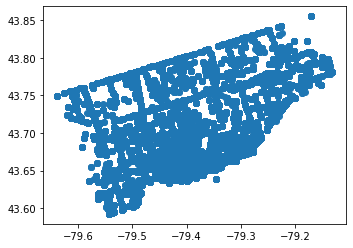

In [340]:
join_7.plot()

In [341]:
#joining speed limit dataframe with radius search of max_distance = 0.00001 = 1 metre
join_8 = join_7.sjoin_nearest(speed_limits,how='inner',lsuffix='collisions',rsuffix='speed_limits',max_distance=0.00001)

/Users/rakeenahmed/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [342]:
#dropping unneccesary columns
join_8 = join_8.drop(columns=['index_speed_limits'])

In [343]:
join_7.shape

(145655, 34)

In [344]:
join_8.shape

(145669, 37)

# Joining Sensitive Zones

In [345]:
#processing geometry column


#replacing the geometry column
sensitive_zones = sensitive_zones.drop(columns=['geometry'])

sensitive_zones['geometry'] = gpd.points_from_xy(sensitive_zones['sensitive_zone_longitude'],sensitive_zones['sensitive_zone_latitude'],crs='EPSG:4326')

#converting to geodataframe
sensitive_zones = gpd.GeoDataFrame(sensitive_zones,geometry=sensitive_zones['geometry'])

#restricting sensitive zones to toronto boundaries
sensitive_zones = sensitive_zones.loc[sensitive_zones.geometry.y<44]
sensitive_zones = sensitive_zones.loc[sensitive_zones.geometry.y>43.5]
sensitive_zones = sensitive_zones.loc[sensitive_zones.geometry.x<-79]
sensitive_zones = sensitive_zones.loc[sensitive_zones.geometry.x>-79.9]

In [346]:
#joining sensitive zones dataframe with radius search of 100 metres
join_9 = join_8.sjoin_nearest(sensitive_zones,how='left',lsuffix='collisions',rsuffix='sensitive_zones',max_distance=0.001)

/Users/rakeenahmed/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [347]:
join_9.shape

(167678, 43)

In [348]:
#dropping unneccesary columns
join_9 = join_9.drop(columns=['index_sensitive_zones','sensitive_zone_name','sensitive_zone_latitude','sensitive_zone_longitude','sensitive_zone_type'])

In [349]:
#filling N/A values where sensitive zone is not present
join_9.sensitive_zone_sensitive_zone.fillna('No',inplace=True)

# Exporting Final Data Frame

In [350]:
#setting new name for final dataframe
collisions_df = join_9

In [351]:
collisions_final.head()

,collisions_month,collisions_day_of_week,collisions_year,collisions_hour,collisions_neighbourhood,collisions_fatalities,collisions_injury_collisions,collisions_longitude,collisions_latitude,collisions_fatal_collisions,...,vehicle_count,pct_vehicles,pct_pedestrians,pct_cyclists,pct_trucks,traffic_cameras_present,road_name_speed_limits,road_class_speed_limits,speed_limit,sensitive_zone_sensitive_zone
eventuniqueid,,,,,,,,,,,,,,,,,,,,,
GO-20168000055,January,Friday,2016,16,LAmoreaux (117),0,NO,-79.319271,43.795851,NO,...,17373,95.064295,4.919289,0.016416,2.26539,No,FINCH AVE E,Major Arterial,60,Yes
GO-20168001220,January,Sunday,2016,17,LAmoreaux (117),0,NO,-79.319271,43.795851,NO,...,17373,95.064295,4.919289,0.016416,2.26539,No,FINCH AVE E,Major Arterial,60,Yes
GO-20168003250,January,Friday,2016,14,LAmoreaux (117),0,NO,-79.319271,43.795851,NO,...,17373,95.064295,4.919289,0.016416,2.26539,No,FINCH AVE E,Major Arterial,60,Yes
GO-20168003473,January,Monday,2016,7,LAmoreaux (117),0,NO,-79.319271,43.795851,NO,...,17373,95.064295,4.919289,0.016416,2.26539,No,FINCH AVE E,Major Arterial,60,Yes
GO-2016143401,January,Sunday,2016,21,LAmoreaux (117),0,NO,-79.319271,43.795851,NO,...,17373,95.064295,4.919289,0.016416,2.26539,No,FINCH AVE E,Major Arterial,60,Yes


In [352]:
#dropping unneeccesary columns
collisions_df = collisions_df.drop(columns=['index_traffic_volumes','location','road_name_speed_limits','road_class_speed_limits'])

In [353]:
#exporting dataframe

#csv
collisions_df.to_csv('/Users/rakeenahmed/Library/CloudStorage/GoogleDrive-rakeenaahmed@gmail.com/My Drive/Centennial/BA 723 - Business Analytics Capstone/Projects/Toronto KSI/Modeling/collisions_df.csv')

#geojson
collisions_df.to_file('/Users/rakeenahmed/Library/CloudStorage/GoogleDrive-rakeenaahmed@gmail.com/My Drive/Centennial/BA 723 - Business Analytics Capstone/Projects/Toronto KSI/Modeling/collisions_df.geojson',driver='GeoJSON')